<ipython-input-3-dc1546cff002>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches['season'] = matches['season'].astype(str).str.extract(r'(\d{4})').astype(int)
<ipython-input-3-dc1546cff002>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches["team1_id"] = team_encoder.transform(matches["team1"])
<ipython-input-3-dc1546cff002>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

 Best RF params: {'n_estimators': 300, 'min_samples_split': 10, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}
 RF Best CV accuracy: 0.6442

 RF Accuracy: 0.7778
              precision    recall  f1-score   support

           0       0.77      0.67      0.71        15
           1       0.78      0.86      0.82        21

    accuracy                           0.78        36
   macro avg       0.78      0.76      0.77        36
weighted avg       0.78      0.78      0.77        36

 Best NN params: {'solver': 'adam', 'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 100), 'alpha': 0.01, 'activation': 'logistic'}

 NN Accuracy: 0.8333
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        15
           1       0.89      0.81      0.85        21

    accuracy                           0.83        36
   macro avg       0.83      0.84      0.83        36
weighted avg     

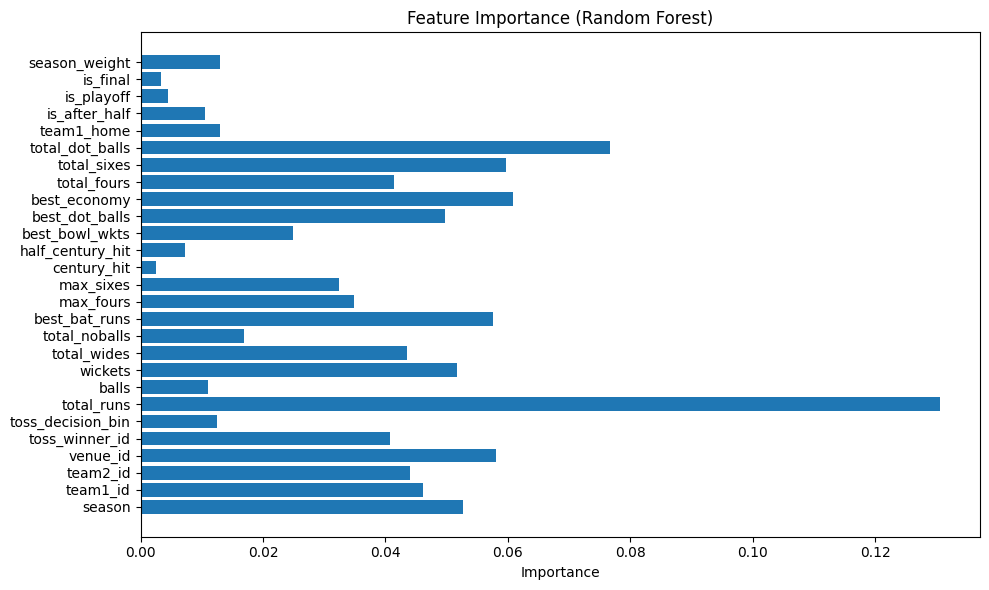

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
import numpy as np

# Load datasets
matches = pd.read_csv("matches.csv")
deliveries = pd.read_csv("deliveries.csv")

# Drop matches with no result
matches = matches.dropna(subset=["winner"])

# Extract numeric season
matches['season'] = matches['season'].astype(str).str.extract(r'(\d{4})').astype(int)

# Encode teams and venues
team_encoder = LabelEncoder()
all_teams = pd.Series(
    matches["team1"].tolist() +
    matches["team2"].tolist() +
    matches["toss_winner"].dropna().tolist()
).unique()
team_encoder.fit(all_teams)
venue_encoder = LabelEncoder()
matches["team1_id"] = team_encoder.transform(matches["team1"])
matches["team2_id"] = team_encoder.transform(matches["team2"])
matches["toss_winner_id"] = team_encoder.transform(matches["toss_winner"])
matches["venue_id"] = venue_encoder.fit_transform(matches["venue"])

# Target variable
matches["team1_win"] = (matches["winner"] == matches["team1"]).astype(int)

# Toss feature
matches["toss_decision_bin"] = matches["toss_decision"].map({"bat": 0, "field": 1})

# Now make a working copy for merges including all match-level columns
df_matches = matches.copy()

# Filter deliveries to first innings
deliveries_first = deliveries[deliveries['inning'] == 1].copy()

# Legal balls count
legal = deliveries_first[~deliveries_first['extras_type'].isin(['wides', 'noballs'])]
legal_balls = legal.groupby('match_id')['ball'] \
    .count().reset_index().rename(columns={'ball':'balls'})

# Extras: wides and no-balls count
wides = deliveries_first[deliveries_first['extras_type'] == 'wides'] \
    .groupby('match_id')['ball'].count().reset_index().rename(columns={'ball':'total_wides'})
noballs = deliveries_first[deliveries_first['extras_type'] == 'noballs'] \
    .groupby('match_id')['ball'].count().reset_index().rename(columns={'ball':'total_noballs'})

# First-innings summary stats
i_summary = (
    deliveries_first.groupby('match_id')
    .agg(total_runs=('total_runs','sum'),
         wickets=('player_dismissed', lambda x: x.notna().sum()))
    .reset_index()
)
i_summary = (
    i_summary
    .merge(legal_balls, on='match_id', how='left')
    .merge(wides, on='match_id', how='left')
    .merge(noballs, on='match_id', how='left')
    .fillna(0)
)

# Best batter stats
bat_stats = (
    deliveries_first.groupby(['match_id','batting_team','batter'])
    .agg(bat_runs=('batsman_runs','sum'),
         fours=('batsman_runs', lambda x: (x==4).sum()),
         sixes=('batsman_runs', lambda x: (x==6).sum()))
    .reset_index().rename(columns={'batter':'batsman'})
)
bat_stats['century'] = (bat_stats['bat_runs'] >= 100).astype(int)
bat_stats['half_century'] = ((bat_stats['bat_runs'] >= 50) & (bat_stats['bat_runs'] < 100)).astype(int)
bat_stats = bat_stats.merge(matches[['id','team1']], left_on='match_id', right_on='id')
bat_stats = bat_stats[bat_stats['batting_team'] == bat_stats['team1']]
best_bat = bat_stats.groupby('match_id').agg(
    best_bat_runs=('bat_runs','max'),
    max_fours=('fours','max'),
    max_sixes=('sixes','max'),
    century_hit=('century','max'),
    half_century_hit=('half_century','max')
).reset_index()

# Best bowler stats
bowl_stats = (
    deliveries_first.groupby(['match_id','bowling_team','bowler'])
    .agg(wkts=('player_dismissed', lambda x: x.notna().sum()),
         dot_balls=('total_runs', lambda x: (x==0).sum()),
         runs_conceded=('total_runs','sum'),
         balls_bowled=('ball','count'))
    .reset_index()
)
bowl_stats['economy'] = bowl_stats['runs_conceded'] / (bowl_stats['balls_bowled']/6)
bowl_stats = bowl_stats.merge(matches[['id','team2']], left_on='match_id', right_on='id')
bowl_stats = bowl_stats[bowl_stats['bowling_team'] == bowl_stats['team2']]
best_bowl = bowl_stats.groupby('match_id').agg(
    best_bowl_wkts=('wkts','max'),
    best_dot_balls=('dot_balls','max'),
    best_economy=('economy','min')
).reset_index()

# Team-level boundary and dot-ball pressure
boundary_stats = (
    deliveries_first.groupby(['match_id','batting_team'])
    .agg(total_fours=('batsman_runs', lambda x: (x==4).sum()),
         total_sixes=('batsman_runs', lambda x: (x==6).sum()))
    .reset_index()
)
boundary_stats = boundary_stats.merge(matches[['id','team1']], left_on=['match_id','batting_team'], right_on=['id','team1'])
boundary_stats = boundary_stats[['match_id','total_fours','total_sixes']].rename(columns={'match_id':'id'})

dot_stats = (
    deliveries_first.groupby(['match_id','bowling_team'])

    .agg(total_dot_balls=('total_runs', lambda x: (x==0).sum()))
    .reset_index()
)
dot_stats = dot_stats.merge(matches[['id','team2']], left_on=['match_id','bowling_team'], right_on=['id','team2'])
dot_stats = dot_stats[['match_id','total_dot_balls']].rename(columns={'match_id':'id'})

# Merge all features
# now df_matches has the encoded columns

df = df_matches.merge(i_summary.rename(columns={'match_id':'id'}), on='id', how='left')
df = df.merge(best_bat.rename(columns={'match_id':'id'}), on='id', how='left')
df = df.merge(best_bowl.rename(columns={'match_id':'id'}), on='id', how='left')
df = df.merge(boundary_stats, on='id', how='left')
df = df.merge(dot_stats, on='id', how='left')
df.fillna(0, inplace=True)

# Home venue indicator
home_venues = {
    'Mumbai Indians':['Wankhede Stadium'],
    'Chennai Super Kings':['MA Chidambaram Stadium'],
    'Kolkata Knight Riders':['Eden Gardens'],
    'Royal Challengers Bangalore':['M Chinnaswamy Stadium'],
    'Delhi Capitals':['Arun Jaitley Stadium','Feroz Shah Kotla'],
    'Sunrisers Hyderabad':['Rajiv Gandhi International Stadium'],
    'Rajasthan Royals':['Sawai Mansingh Stadium'],
    'Punjab Kings':['IS Bindra Stadium','Punjab Cricket Association Stadium'],
    'Gujarat Titans':['Narendra Modi Stadium'],
    'Lucknow Super Giants':['BRSABV Ekana Cricket Stadium']
}
df['team1_home'] = df.apply(lambda r: int(r['venue'] in home_venues.get(r['team1'],[])), axis=1)

# Match stage features



# Match stage features
df = df.sort_values(['season','id']).reset_index(drop=True)
df['match_number'] = df.groupby('season').cumcount()+1
df['total_matches_in_season'] = df.groupby('season')['id'].transform('count')
df['is_after_half'] = (df['match_number'] > df['total_matches_in_season']/2).astype(int)
df['is_playoff'] = df['match_number'] >= (df['total_matches_in_season']-3)
df['is_final'] = df['match_number'] == df['total_matches_in_season']

# Season weight
current_season = df['season'].max()
two_years = current_season - 2
df['season_weight'] = df['season'].apply(lambda x: 3 if x==current_season else (2 if x>two_years else 1))

# Prepare features and target
FEATURES = [
    'season','team1_id','team2_id','venue_id',
    'toss_winner_id','toss_decision_bin',
    'total_runs','balls','wickets','total_wides','total_noballs',
    'best_bat_runs','max_fours','max_sixes','century_hit','half_century_hit',
    'best_bowl_wkts','best_dot_balls','best_economy',
    'total_fours','total_sixes','total_dot_balls',
    'team1_home','is_after_half','is_playoff','is_final','season_weight'
]
X = df[FEATURES]
y = df['team1_win']

# Continue with train/test split and modeling as before...


df_2024 = df[df['season'] == current_season]
df_past = df[df['season'] < current_season]
X_train_2024, X_test_2024, y_train_2024, y_test_2024 = train_test_split(
    df_2024[FEATURES], df_2024['team1_win'], test_size=0.5, random_state=42
)
X_train = pd.concat([df_past[FEATURES], X_train_2024])
y_train = pd.concat([df_past['team1_win'], y_train_2024])
X_test, y_test = X_test_2024, y_test_2024

# -------- Random Forest --------
param_grid_rf = {
    'n_estimators': [100,200,300,500],
    'max_depth': [None,10,15,20],
    'max_features': ['sqrt','log2'],
    'min_samples_split': [2,5,10],
    'class_weight': [None,'balanced'],
    'bootstrap': [True,False]
}
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), param_grid_rf,
    n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)
rf_search.fit(X_train, y_train, sample_weight=df.loc[y_train.index, 'season_weight'])
best_rf = rf_search.best_estimator_
print(" Best RF params:", rf_search.best_params_)
print(f" RF Best CV accuracy: {rf_search.best_score_:.4f}")

# Evaluate RF
y_pred_rf = best_rf.predict(X_test)
print(f"\n RF Accuracy: {accuracy_score(y_test,y_pred_rf):.4f}")
print(classification_report(y_test,y_pred_rf))

# -------- Neural Network (MLP) --------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid_nn = {
    'hidden_layer_sizes': [(50,),(100,),(50,50),(100,100)],
    'activation': ['relu','tanh','logistic'],
    'solver': ['adam','sgd'],
    'alpha': [0.0001,0.001,0.01],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [200,300,500]
}
mlp = MLPClassifier(random_state=42)
nn_search = RandomizedSearchCV(
    mlp, param_grid_nn, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)
nn_search.fit(X_train_scaled, y_train)
best_nn = nn_search.best_estimator_
print(" Best NN params:", nn_search.best_params_)

# Evaluate NN
y_pred_nn = best_nn.predict(X_test_scaled)
print(f"\n NN Accuracy: {accuracy_score(y_test,y_pred_nn):.4f}")
print(classification_report(y_test,y_pred_nn))

# Feature Importance
importances = best_rf.feature_importances_
plt.figure(figsize=(10,6))
plt.barh(FEATURES, importances)
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# -------- User-Friendly Input Mapping --------
team_names = list(team_encoder.classes_)
venue_names = list(venue_encoder.classes_)

def get_team_id(name):
    return team_encoder.transform([name])[0]

def get_venue_id(name):
    return venue_encoder.transform([name])[0]


